## Logistic Regression to Predict High or Low Traffic Accident Severity

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('C:/data/Accidents.csv')

## Feature Engineering and Subsetting

In [3]:
# Reduce traffic Severity from four categories down to two for Logistic Regression
data['Severity01'] = data['Severity'].apply(lambda x: 1 if x >= 3 else 0)
data['SeverityLoHi'] = data['Severity'].apply(lambda x: "High" if x >= 3 else "Low")

In [4]:
# These features with a high percentage of single values made binary
data['DistanceZero'] = data['Distance(mi)'].apply(lambda x: 1 if x == 0 else 0)
data['PrecipitationZero'] = data['Precipitation(in)'].apply(lambda x: 1 if x == 0 else 0)
data['VisibilityTen'] = data['Visibility(mi)'].apply(lambda x: 1 if x == 10 else 0)

In [5]:
# Convert Civil Twilight from Day Night to 0 1
data['DayNight01'] = data['Civil_Twilight'].apply(lambda x: 1 if x == 'Night' else 0)

In [6]:
subset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1)

In [7]:
subset = pd.get_dummies(data = subset, columns = ['Weather_Group', 'weekday', 'hour'] )

In [21]:
subset.columns

Index(['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Duration(m)',
       'Severity01', 'DistanceZero', 'PrecipitationZero', 'VisibilityTen',
       'DayNight01', 'Weather_Group_Clear', 'Weather_Group_Cloudy',
       'Weather_Group_Heavy Precip', 'Weather_Group_Light Precip',
       'Weather_Group_Obscured', 'Weather_Group_Windy', 'weekday_Fri',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22'

In [22]:
subset.shape

(2717404, 64)

In [25]:
# In EDA, only correlation over 50% was between Temperature and Wind Chill.  Remove Wind Chill.
old_corr = subset[['Temperature(F)', 'Wind_Chill(F)']]
corr = old_corr.corr(method = 'pearson')
print(corr)

                Temperature(F)  Wind_Chill(F)
Temperature(F)        1.000000       0.833849
Wind_Chill(F)         0.833849       1.000000


In [9]:
subset = subset.drop(['Wind_Chill(F)'], axis = 1)

In [10]:
# Separate X, y
y = subset.Severity01
X = subset.drop(['Severity01'], axis=1)

In [30]:
X.shape

(2717404, 62)

In [36]:
features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Duration(m)',
       'DistanceZero', 'PrecipitationZero', 'VisibilityTen',
       'DayNight01', 'Weather_Group_Clear', 'Weather_Group_Cloudy',
       'Weather_Group_Heavy Precip', 'Weather_Group_Light Precip',
       'Weather_Group_Obscured', 'Weather_Group_Windy', 'weekday_Fri',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23']

## First Logistic Regression

In [11]:
# Create training, test, validate sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=7)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(1956530, 62)
(543481, 62)
(217393, 62)
(1956530,)
(543481,)
(217393,)


In [29]:
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 7, solver = 'saga'))]

In [30]:
pipeline = Pipeline(steps)

In [31]:
logreg_scaled = pipeline.fit(X_train, y_train)

In [32]:
# Accuracy on testing
print("The testing accuracy is ", logreg_scaled.score(X_test, y_test))

The testing accuracy is  0.6938973027575941


## Feature Ranking

In [49]:
# Plot the Beta values of a Logistic Regression based on the Features provided
logreg = LogisticRegression(random_state = 7, solver = 'saga', penalty='l1')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
logreg.fit(X_train,y_train)
std_coef = logreg.coef_.reshape(-1,1).tolist()
feature_names = [feature.title() for feature in features]
coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
coef_df['abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
pd.set_option('display.max_rows', None)
print(coef_df)

                                coef
Traffic_Signal             -0.135802
Distance(Mi)                0.100135
Distancezero               -0.073732
Crossing                   -0.061685
Daynight01                  0.041559
Weekday_Sat                 0.036909
Weekday_Sun                 0.032850
Junction                    0.032669
Precipitationzero          -0.026913
Hour_8                     -0.021010
Pressure(In)               -0.020345
Weather_Group_Clear        -0.017879
Hour_7                     -0.017450
Weekday_Tue                -0.017421
Weekday_Wed                -0.017111
Weekday_Mon                -0.015440
Wind_Speed(Mph)             0.014852
Station                    -0.013350
Stop                       -0.013228
Weekday_Thu                -0.012335
Amenity                    -0.010529
Weather_Group_Cloudy        0.009092
Weekday_Fri                -0.009011
Visibility(Mi)             -0.008965
Hour_10                    -0.007500
Hour_11                    -0.007413
H

C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


An interesting ranking.  Weather is not well represented at the top.  Traffic signals, intersections and crosswalks are far more indicative of traffic severity than weather.  One of the created binary fields, Precipitation01, made the top ten.  Binary Distance is redundant as Distance(mi) is ranked second.  The weekend ranked well, identified as much less frequent accident days during the EDA, as well as the importance of commute times beginning at 7-8 am.  Pressure can indicate good weather when it increases and storms when it falls.  I am surprised to see Heavy Precipitation ranking so low, maybe due to causing slower travel speeds.  

The line will be drawn at coefficients of at least +/- 0.01 away from zero.

In [87]:
columns_to_keep = ['Traffic_Signal', 'Distance(mi)', 'Crossing', 'DayNight01', 'weekday_Sat', 'weekday_Sun', 'Junction', 'PrecipitationZero', 'hour_8', 'hour_7', 'Pressure(in)', 'Weather_Group_Clear', 'weekday_Mon', 'weekday_Tue', 'weekday_Wed', 'weekday_Thu', 'Wind_Speed(mph)', 'Station', 'Stop', 'Amenity']

## Second Logistic Regression

In [88]:
# Split X, y kept columns
X2 = subset[columns_to_keep]

In [91]:
# Create training, test, validate sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, random_state=7)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2_train, y2_train, test_size = 0.1, random_state=7)
print(X2_train.shape)
print(X2_test.shape)
print(X2_valid.shape)
print(y2_train.shape)
print(y2_test.shape)
print(y2_valid.shape)

(1956530, 20)
(543481, 20)
(217393, 20)
(1956530,)
(543481,)
(217393,)


In [93]:
steps2 = [('scaler2', StandardScaler()), ('logreg2', LogisticRegression(random_state = 7, solver='saga'))]

In [94]:
pipeline2 = Pipeline(steps2)

In [95]:
logreg2_scaled = pipeline2.fit(X2_train, y2_train)

In [96]:
# Accuracy on testing2
print("The testing2 accuracy is ", logreg2_scaled.score(X2_test, y2_test))

The testing2 accuracy is  0.690029642250603


While retaining only 1/3rd of the features, we only lost 1/3rd of a percent off our accuracy.

# Evaluate the Linear Regression Model

In [97]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline2, X2, y, cv=5)

In [98]:
# CV Scores
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.68920533 0.69257435 0.68865333 0.68504879 0.68500221]
Average 5-Fold CV Score: 0.6880968000729402


I don't believe there is overfitting due to the low variation in cross-validation.

In [99]:
# Predict class labels for samples in X
y2_pred = logreg2_scaled.predict(X2_test)

In [100]:
# Probability estimates
pred_proba = logreg2_scaled.predict_proba(X2_test)

In [101]:
# Classification report
y2_pred = logreg2_scaled.predict(X2_test)
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80    367866
           1       0.57      0.16      0.25    175615

    accuracy                           0.69    543481
   macro avg       0.64      0.55      0.53    543481
weighted avg       0.66      0.69      0.63    543481



The high recall for 0 is an indication most Low-severity traffic accidents were predicted correctly.  The weakness appears to be identifying High Severity.

In [102]:
print(confusion_matrix(y2_test, y2_pred))

[[346864  21002]
 [147461  28154]]


In [103]:
# confusion matrix percentages
cm = confusion_matrix(y2_test, y2_pred)
cmpct = cm / cm.sum(axis=1).reshape(-1,1)
print(cmpct)

[[0.94290856 0.05709144]
 [0.8396834  0.1603166 ]]


False positives in the lower left corner appear to drive the inaccuracy.  They are actual high severity traffic (1) but predicted incorrectly as low severity (0).  This is a substantial problem as motorists would be led erroneously into waiting in extensive traffic delays.  High severity accident traffic was only correctly predicted 16% of the time.  

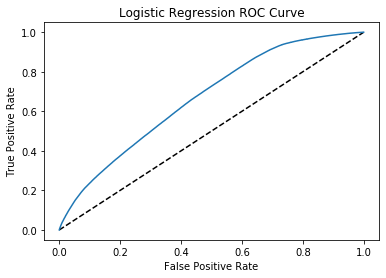

In [104]:
# Plotting the ROC curve
y2_pred_prob = pipeline2.predict_proba(X2_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y2_test, y2_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')
plt.show()

In [105]:
roc_auc_score(y2_test, y2_pred_prob)

0.6679636871301144

This classifier has a poor discriminative ability.

## Comparison to Random Forest

In [5]:
rfset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1)


In [6]:
# Run a plain RF on recreated original X, y
from sklearn.ensemble import RandomForestClassifier

# Due to robustness of Random Forest classifiers, the following pre-processing for Logistic Regression was not made:
    # Dropping high correlation feature Wind Chill
    # Creating binary dummy features for very low variance 'Distance', 'Precipitation', 'Visibility'

rfset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'PrecipitationZero', 'DistanceZero', 'VisibilityTen'], axis = 1)
rfset = pd.get_dummies(data = rfset, columns = ['Weather_Group', 'weekday', 'hour'] )

# Separate X, y, train, test, validate
yrf = rfset.Severity01
Xrf = rfset.drop(['Severity01'], axis=1)

Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(Xrf, yrf, test_size = 0.2, random_state=7, stratify=y)
Xrf_train, Xrf_valid, yrf_train, yrf_valid = train_test_split(Xrf_train, yrf_train, test_size = 0.1, random_state=7, stratify=y)

rf = RandomForestClassifier()
rf.fit(Xrf_train, yrf_train)

yrf_pred= rf.predict(Xrf_test) 
print("RF Accuracy: ", rf.score(Xrf_test, yrf_test))


RF Accuracy:  0.7395180328291145
[[325128  42738]
 [ 98829  76786]]


In [7]:
# Confusion Matrix
pd.crosstab(yrf_test, yrf_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,325128,42738
1,98829,76786


In [15]:
# Confusion Matrix percentages
cm = confusion_matrix(yrf_test, yrf_pred)
cmpct = np.round(cm / cm.sum(axis=1).reshape(-1,1), 2)
print(cmpct)

[[0.88 0.12]
 [0.56 0.44]]


Significant improvement over Logistic Regression identifying High Severity with True Negative quadrant more than doubling.  A 30% reduction of False Positives, which are a concern, predicting incorrectly low severity traffic when in actuality it is severe.

Text(0.5, 1.0, 'Low vs High Accident Traffic Severity Counts')

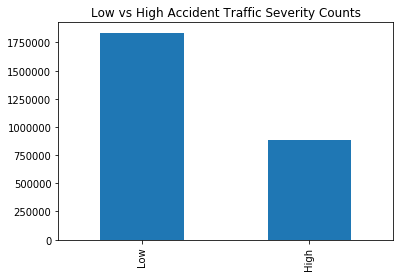

In [18]:
# Twice as many Low Severity Accidents vs. High Severity
data.SeverityLoHi.value_counts().plot(kind='bar')
plt.title('Low vs High Accident Traffic Severity Counts')


In [6]:
# Are high severity incidents under-represented?  Equalize count with low severity.
high_count = rfset.Severity01[rfset.Severity01 == 1].count()
equaldf = rfset[rfset.Severity01 == 1]
lows = rfset[rfset.Severity01 == 0].sample(n=high_count, random_state=7)
equaldf = equaldf.append(lows)
equaldf.Severity01.value_counts()

1    880347
0    880347
Name: Severity01, dtype: int64

In [37]:
# Check improved Confusion Matrix with equal category counts
yrfe = equaldf.Severity01
Xrfe = equaldf.drop(['Severity01'], axis=1)

Xrfe_train, Xrfe_test, yrfe_train, yrfe_test = train_test_split(Xrfe, yrfe, test_size = 0.2, random_state=7)
Xrfe_train, Xrfe_valid, yrfe_train, yrfe_valid = train_test_split(Xrfe_train, yrfe_train, test_size = 0.1, random_state=7)

rfe = RandomForestClassifier()
rfe.fit(Xrfe_train, yrfe_train)

yrfe_pred= rfe.predict(Xrfe_test) 
print("RF Accuracy: ", rfe.score(Xrfe_test, yrfe_test))

pd.crosstab(yrfe_test, yrfe_pred, rownames=['Actual Result'], colnames=['Predicted Result'])
cme = confusion_matrix(yrfe_test, yrfe_pred)
cmpcte = np.round(cme / cme.sum(axis=1).reshape(-1,1), 2)
print(cmpcte)

RF Accuracy:  0.7081237806661574
[[0.68 0.32]
 [0.26 0.74]]


I am very pleased to see the False Positives cut by 50% further, and a higher rate of identifying High Severity Accident Traffic than Low.  As noted previously, the model needs to minimize false positives, which is High Severity incorrectly identified as Low Severity.

If a motorist is told an accident will cause High Severity traffic, in error, they will take an alternate route, or be pleasantly surprised when actual traffic is less than expected, and thus a much less problematic prediction than the opposite.

In [38]:
# Classification report
print(classification_report(yrfe_test, yrfe_pred))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70    175525
           1       0.70      0.74      0.72    176614

    accuracy                           0.71    352139
   macro avg       0.71      0.71      0.71    352139
weighted avg       0.71      0.71      0.71    352139



The weighted average F1 sore increased from 64 to 71.  

In [39]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(rfe, Xrfe, yrfe, cv=5)

In [40]:
# CV Scores
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.58522913 0.62667867 0.55601907 0.62823203 0.60886925]
Average 5-Fold CV Score: 0.6010056306567861


Cross-validation scores are consistent, avoiding over-fitting.

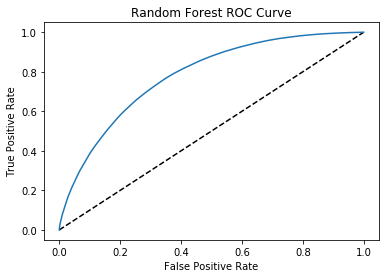

In [41]:
# Plotting the ROC curve
yrfe_pred_prob = rfe.predict_proba(Xrfe_test)[:, 1]
fpr, tpr, thresholds = roc_curve(yrfe_test, yrfe_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.show()

In [42]:
print("AUC: ", roc_auc_score(yrfe_test, yrfe_pred_prob))

AUC:  0.7794993341545084


Area under curve improved from 66.8 to 77.9

In [43]:
feature_importances = pd.DataFrame(rfe.feature_importances_,
                                   index = Xrfe_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
pd.set_option('display.max_rows', 65)
display(feature_importances)
pd.reset_option('display.max_rows')

,importance
Duration(m),0.141785
Wind_Chill(F),0.109764
Pressure(in),0.103189
Temperature(F),0.096587
Humidity(%),0.096222
Wind_Speed(mph),0.079236
Distance(mi),0.054535
Precipitation(in),0.051111
Traffic_Signal,0.045925
Visibility(mi),0.023941


The Random Forest relied considerably more upon weather features than Logistic Regression, in nine of the first ten ranks.  Traffic Signal and Crosswalk are again the top non-weather features, followed by all of the days close together.

Is there more improvement ignoring days, hours, weather groups and everything lower?

In [8]:
# Rerun with most important features
from sklearn.ensemble import RandomForestClassifier
yrfe = equaldf.Severity01
Xrfe11 = equaldf[['Duration(m)', 'Wind_Chill(F)', 'Pressure(in)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Distance(mi)', 'Precipitation(in)', 'Traffic_Signal', 'Visibility(mi)', 'Crossing']]

Xrfe11_train, Xrfe11_test, yrfe_train, yrfe_test = train_test_split(Xrfe11, yrfe, test_size = 0.2, random_state=7)
Xrfe11_train, Xrfe11_valid, yrfe_train, yrfe_valid = train_test_split(Xrfe11_train, yrfe_train, test_size = 0.1, random_state=7)

rfe11 = RandomForestClassifier()
rfe11.fit(Xrfe11_train, yrfe_train)

yrfe_pred= rfe11.predict(Xrfe11_test) 
print("RF Accuracy: ", rfe11.score(Xrfe11_test, yrfe_test))

pd.crosstab(yrfe_test, yrfe_pred, rownames=['Actual Result'], colnames=['Predicted Result'])
cme11 = confusion_matrix(yrfe_test, yrfe_pred)
cmpcte11 = np.round(cme11 / cme11.sum(axis=1).reshape(-1,1), 2)
print(cmpcte11)

RF Accuracy:  0.686714621214918
[[0.64 0.36]
 [0.27 0.73]]


Slightly underperforming what we had previously with all the fields.  False Positives only went up 1 point, but reduced from 60 fields to 11 to lesson computational load for hyperparameter tuning.

## Hyperparameter Tuning

In [9]:
# Random Hyperparameter Grid
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
#               'bootstrap': bootstrap}

# Random Search Training

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=7, n_jobs = -1)
# Fit the random search model
rfc_random.fit(Xrfe11_valid, yrfe_valid)

rfc_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.1min
C:\Users\ggibs\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 83.3min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20}

In [12]:
rf_tune = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 4, max_depth = 20)
rf_tune.fit(Xrfe11_train, yrfe_train)

ytune_pred= rf_tune.predict(Xrfe11_test) 
print("RF Accuracy: ", rf_tune.score(Xrfe11_test, yrfe_test))

pd.crosstab(yrfe_test, ytune_pred, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_tune = confusion_matrix(yrfe_test, ytune_pred)
cmpct_tune = np.round(cm_tune / cm_tune.sum(axis=1).reshape(-1,1), 2)
print(cmpct_tune)

RF Accuracy:  0.6810577641215543
[[0.63 0.37]
 [0.27 0.73]]


Hyperparameter tuning on the reduced feature count was not an improvement.  True Positives declined 1 point and accuracy fell half a percent.